<a href="https://colab.research.google.com/github/stsibin/ML-projects/blob/master/Caltech10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:

import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/Kaggle Datasets/CalTech Light/CalTech.zip","r") as z:
    z.extractall(".")

In [ ]:

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [ ]:


dataset = '/content/CalTech'

train_directory = os.path.join(dataset, '/content/CalTech/train')
valid_directory = os.path.join(dataset, '/content/CalTech/valid')
test_directory = os.path.join(dataset, '/content/CalTech/test')


bs = 32


num_classes = len(os.listdir(valid_directory))-1 
print(num_classes)

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

9
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [ ]:
train_data_size, valid_data_size, test_data_size

(600, 100, 409)

In [ ]:

resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to('cuda:0')

In [ ]:

for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
resnet50

In [ ]:

fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.LogSoftmax(dim=1) 
)

resnet50 = resnet50.to('cuda:0')

In [ ]:

loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        model.train()

        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

num_epochs = 100
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

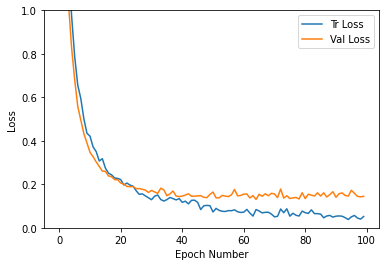

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

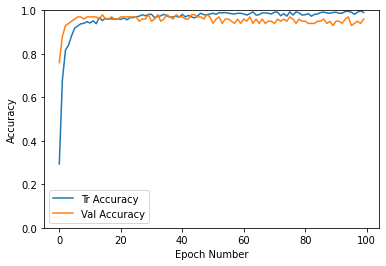

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
def computeTestSetAccuracy(model, loss_criterion):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    with torch.no_grad():
        model.eval()

        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [ ]:
model = torch.load('CalTech_model_96.pt')
computeTestSetAccuracy(model,loss_func)

Test Batch number: 000, Test: Loss: 0.2162, Accuracy: 0.9688
Test Batch number: 001, Test: Loss: 0.0592, Accuracy: 0.9688
Test Batch number: 002, Test: Loss: 0.3476, Accuracy: 0.8750
Test Batch number: 003, Test: Loss: 0.2991, Accuracy: 0.8750
Test Batch number: 004, Test: Loss: 0.2030, Accuracy: 0.9375
Test Batch number: 005, Test: Loss: 0.1234, Accuracy: 0.9375
Test Batch number: 006, Test: Loss: 0.1295, Accuracy: 0.9375
Test Batch number: 007, Test: Loss: 0.1313, Accuracy: 0.9375
Test Batch number: 008, Test: Loss: 0.1612, Accuracy: 0.9688
Test Batch number: 009, Test: Loss: 0.1732, Accuracy: 0.9375
Test Batch number: 010, Test: Loss: 0.2413, Accuracy: 0.9062
Test Batch number: 011, Test: Loss: 0.2252, Accuracy: 0.9062
Test Batch number: 012, Test: Loss: 0.2176, Accuracy: 0.9200
Test accuracy : 0.9290953555433558


In [ ]:
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)   
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)   
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Predcition 1 : llama , Score:  0.9884298
Predcition 2 : ostrich , Score:  0.010868372
Predcition 3 : giraffe , Score:  0.0004628347


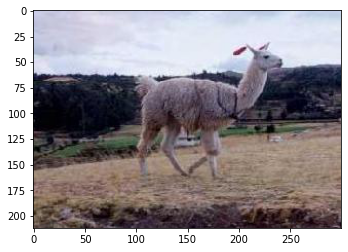

In [ ]:

dataset = '/content/CalTech/test'
model = torch.load('CalTech_model_96.pt')
predict(model, '/content/CalTech/test/llama/134_0078.jpg')